In [1]:
import mlc_func as mlcf
import numpy as np
import pandas as pd
import keras
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
def create_target_file(baseline, reference, output, offset = 0):
    targets = np.genfromtxt(reference, delimiter = ',') -\
        np.genfromtxt(baseline, delimiter = ',') - offset
#     species = np.array(['o','h','h']*int(len(targets)/3)).reshape(-1,1)
#     targets = np.concatenate([targets,species], axis = 1)
    pd.DataFrame(targets).to_csv(output, index = None, header = None)

In [77]:
# basepath_feat = '../data/PBE/szp/basis_long_elf.json_processed/'
# basepath_tar = '../data/PBE/szp/'
# revpath_tar = '../data/MB-pol'

basepath_feat = '../data/BH/dz_custom_padded/basis_nocore_elf.json_processed/'
basepath_tar = '../data/BH/dz_custom_padded/'
revpath_tar = '../data/MB-pol/'

# systems = ['monomers','dimers','trimers']
systems = ['16p16']
mono_offset = 0
n_mol = [3,2,1]
# filters = [([True,True] + [False]*10)*3000]

for s,nm in zip(systems, n_mol):
    create_target_file(basepath_tar +'/{}.forces'.format(s),
                      revpath_tar + '/{}.forces'.format(s),
                      basepath_tar +'/{}_targets.forces'.format(s), mono_offset*nm)
        
feature_src = [basepath_feat + s +'_processed.hdf5' for s in systems]
target_src = [basepath_tar +'/' + s +'_targets.forces' for s in systems]
traj_src = [basepath_tar +'/' + s +'.traj' for s in systems]
filters = np.genfromtxt('../data/BH/dz_custom_padded/filter.idx', dtype =bool)
filters = np.array([filters, filters]).T.flatten()
nn = mlcf.ml.build_force_mlcf(feature_src, target_src,traj_src, filters =[filters], automask_std = 1e-3,
                                  autofilt_percent = 0.005, species = 'h')


{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
(16384, 8)


In [66]:
old_scaler = nn.scaler

In [67]:
nn.load_all('../../elf_models/mlcf_master/16p16/pbedz_mbp_elf/')

/home/sebastian/miniconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [68]:
nn.X_test = nn.scaler.transform(old_scaler.inverse_transform(nn.X_test))
nn.X_train = nn.scaler.transform(old_scaler.inverse_transform(nn.X_train))
nn.X_valid = nn.scaler.transform(old_scaler.inverse_transform(nn.X_valid))

ValueError: operands could not be broadcast together with shapes (1229,5) (6,) (1229,5) 

In [60]:
# nn.model = keras.models.load_model('../../elf_models/mlcf_master/16p16/pbesz_mbp_long/force_o')

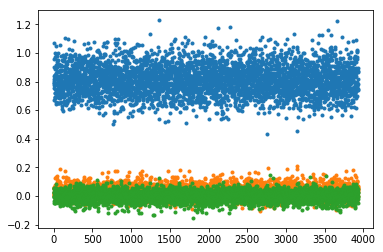

In [78]:
plot(nn.y_train,ls = '', marker = '.')


In [42]:
# learning_curve = nn.learning_curve(steps=8)

In [79]:
nn.nodes_per_layer = 16

In [80]:
nn.train(early_stopping=True, b=1e-8,batch_size=500, restart = False)

--------Epoch = 0----------
Training loss || Validation loss
     0.850480 ||      0.849165
--------Epoch = 500----------
Training loss || Validation loss
     0.053843 ||      0.054216
--------Epoch = 1000----------
Training loss || Validation loss
     0.052986 ||      0.053572
--------Epoch = 1500----------
Training loss || Validation loss
     0.052728 ||      0.053468
--------Epoch = 2000----------
Training loss || Validation loss
     0.052537 ||      0.053464
--------Epoch = 2500----------
Training loss || Validation loss
     0.052323 ||      0.053391


0

======== Evaluation on test set =============
              RMSE =  0.0503
              MAE = 0.0362
              Max. abs. error = 0.2957


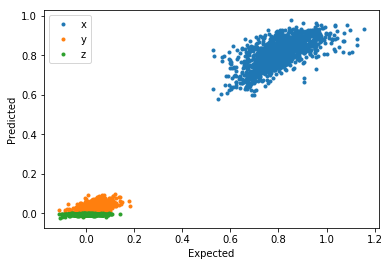

{'rmse': 0.05031633905684814,
 'mae': 0.03617726942386283,
 'max': 0.29565162250033084}

In [81]:
nn.evaluate(plot=True, on='test')

======== Evaluation on test set =============
              RMSE =  0.0723
              MAE = 0.0562
              Max. abs. error = 0.3088


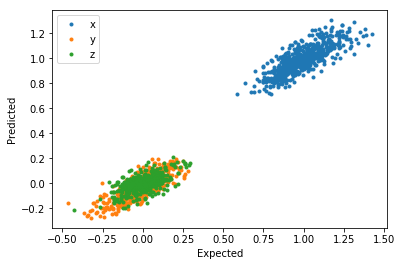

{'rmse': 0.07233807967861908,
 'mae': 0.056155483626236125,
 'max': 0.30876534024360963}

In [74]:
nn.evaluate(plot=True, on='test')

In [82]:
nn.save_all('../../elf_models/mlcf_master/16p16/bh_mbp_elf/', override=False)

In [54]:
ensemble = mlcf.ml.Ensemble_Network(nn)

In [57]:
ensemble.train_next()

Training model: 2
--------Epoch = 0----------
Training loss || Validation loss
     0.690111 ||      0.689123
--------Epoch = 500----------
Training loss || Validation loss
     0.050323 ||      0.049841
--------Epoch = 1000----------
Training loss || Validation loss
     0.048252 ||      0.048288
--------Epoch = 1500----------
Training loss || Validation loss
     0.047829 ||      0.048089
--------Epoch = 2000----------
Training loss || Validation loss
     0.047680 ||      0.048073


KeyboardInterrupt: 

In [67]:
np.std(ensemble.std_predict(nn.X_test, processed=True), axis = 0)

array([0.00567823, 0.00177418, 0.00192366], dtype=float32)